# Final - James Guo (zg268)

## Training/test split (5pts)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
Labels = pd.read_csv('Labels.txt', sep='\t')
UniProt2Seq = pd.read_csv('UniProt2Seq.txt', sep='\t')
Expasy_AA_Scales = pd.read_csv('Expasy_AA_Scales.txt', sep='\t')

In [3]:
UniProt2Seq.AA.value_counts(ascending=True)

U        1
X        1
W     6477
C     9068
M    12094
H    12681
Y    16637
F    20696
Q    23294
N    23354
R    28514
I    28634
D    29907
P    29911
T    30581
K    33709
V    35199
G    37443
E    38569
S    40325
A    40816
L    51044
Name: AA, dtype: int64

In [4]:
Expasy_AA_Scales['Amino Acid'].values

array(['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q',
       'P', 'S', 'R', 'T', 'W', 'V', 'Y'], dtype=object)

**I noticed 'X' and 'U' are not in `Expasy_AA_Scales` column `Amino Acid`. I will drop these 2 observations.**

In [5]:
index_to_drop = [UniProt2Seq.loc[UniProt2Seq['AA'] == 'U'].index, UniProt2Seq.loc[UniProt2Seq['AA'] == 'X'].index]
UniProt2Seq.drop([index_to_drop[0][0], index_to_drop[1][0]], axis=0, inplace=True)

In [6]:
Labels.Label.value_counts()

0    296315
1     81999
Name: Label, dtype: int64

**I noticed that the number of `0` is almost threefold the number of `1`, leading to class imbalance. I will down-sample class `0`.**

In [7]:
Labels_major= Labels[Labels.Label==0]
Labels_minor = Labels[Labels.Label==1]
Labels_major_downsampled = Labels_major.sample(len(Labels_minor), replace=False)
df = Labels_major_downsampled.append(Labels_minor)
df.sort_index(inplace=True)

In [8]:
df_train, df_test = train_test_split(df, test_size=0.3)

## Feature engineering (20pts)

**I will set the index of `Labels` and `UniProt2Seq` to be (`UniProt`, `Position`) , and the index of `Expasy_AA_Scales` to be `Amino Acid`.**

In [9]:
Labels.set_index(['UniProt', 'Position'], inplace=True)
UniProt2Seq.set_index(['UniProt', 'Position'], inplace=True)
Expasy_AA_Scales.set_index('Amino Acid', inplace=True)

In [10]:
df_train_new = df_train.copy()

**I will create an empty column called `AA` in `df_train_new`. I will set the index of `df_train_new` to be (`UniProt`, `Position`), and fill the corresponding `AA` values from `UniProt2Seq` into column `AA` in `df_train_new`.**

In [11]:
df_train_new['AA'] = ''
df_train_new.set_index(['UniProt', 'Position'], inplace=True)
df_train_new.sort_index(inplace=True)
for i in df_train_new.index:
    df_train_new.loc[i, 'AA'] = UniProt2Seq.loc[i].AA

In [12]:
df_train_new.sample(5)

,,Label,AA
UniProt,Position,,
P19367,474,1,L
P42227,382,0,R
P23919,57,1,L
P30429,185,0,D
Q96QU1,944,0,P


**`get_neighbor(ID)`:** return a list of the neighboring AA letters within a 5-window with the given ID as the center.<br><br>
**`get_ave(result)`:** return a pandas Series that contains the average of each feature.

In [13]:
def get_neighbor(ID):
    UniProt = ID[0]
    pos = ID[1]
    length = len(UniProt2Seq.loc[UniProt])
    if pos in [1, 2]:
        temp = UniProt2Seq.loc[UniProt][:5]
    elif pos in [length, length-1]:
        temp = UniProt2Seq.loc[UniProt][length-4:]
    else:
        temp = UniProt2Seq.loc[UniProt][pos-3:pos+2]
    return list(temp.AA)


def get_ave(result):
    return Expasy_AA_Scales.loc[result].mean()

I will call `get_ave(result)` on the returned list after calling `get_neighbor(ID)` for each index in the training set, and append the returned Series one by one to an empty DataFrame called `df_avg`.

In [14]:
df_avg = pd.DataFrame()
for i in df_train_new.index:
    df_avg = df_avg.append(get_ave(get_neighbor(i)), ignore_index=True)

The correlation coefficient measures the strength of the relationship between two features. If the absolute value of the correlation coefficient is very high, that means the relationship between these two features is very high, **i.e., they are redundant features**. So, I will not include features whose absolute values of correlation coefficients are bigger than 0.8, 

In [15]:
corr_matrix = df_avg.corr()
for i in range(len(corr_matrix)):
    for x in range(len(corr_matrix.columns)):
        if corr_matrix.iloc[i, x] != float(1) and abs(corr_matrix.iloc[i, x]) > 0.8:
            corr_matrix.iloc[i, x] = np.nan
corr_matrix.dropna(inplace=True)
features = list(corr_matrix.index)
print('Selected Features: \n\n' + str(features))

Selected Features: 

['%_accessible_residues', 'Average_flexibility', 'Bulkiness', 'Hphob__Welling_&_al', 'Number_of_codons', 'Ratio_hetero_endside', 'Recognition_factors', 'Relative_mutability']


## Model selection (10pts)

Because `Label` is categorical variable, I will use three classifiers as models: Logistic Regression, Decission Tree Regressor, Random Forest. 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

- Logistic Regression

In [17]:
log_model = LogisticRegression().fit(df_avg[features], df_train_new['Label'])
log_model_accuracy = log_model.score(df_avg[features], df_train_new['Label'])
print('Logistic Regression accuracy: {:.3f}'.format(log_model_accuracy))

Logistic Regression accuracy: 0.594


- Decission Tree Regressor

In [18]:
tree_reg = DecisionTreeRegressor().fit(df_avg[features], df_train_new['Label'])
tree_reg_accuracy = tree_reg.score(df_avg[features], df_train_new['Label'])
print('Decission Tree Regressor accuracy: {:.3f}'.format(tree_reg_accuracy))

Decission Tree Regressor accuracy: 0.367


- Random Forest

In [19]:
forest_reg = RandomForestRegressor().fit(df_avg[features], df_train_new['Label'])
forest_reg_accuracy = forest_reg.score(df_avg[features], df_train_new['Label'])
print('Random Forest accuracy: {:.3f}'.format(forest_reg_accuracy))

Random Forest accuracy: 0.354


Among the accuracy scores of the three models, I observed the Logistic Regression model has the highest accuracy score. Then, I will use cross-validation to compare the cross-validation scores of these three models.

## Cross-validation (5pts)

In [20]:
def cross_validation(reg):
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(reg, df_avg[features], df_train_new['Label'], scoring = "neg_mean_squared_error", cv = 10)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [21]:
print('Logistic Regression: \n')
display_scores(cross_validation(log_model))
print('\n')
print('Decission Tree Regressor: \n')
display_scores(cross_validation(tree_reg))
print('\n')
print('Random Forest: \n')
display_scores(cross_validation(forest_reg))

Logistic Regression: 

Scores: [0.6281714  0.63671084 0.63492983 0.63732619 0.6400539  0.64951067
 0.63506701 0.63835044 0.62875321 0.62757441]
Mean: 0.6356447896397599
Standard deviation: 0.0062634533959885315


Decission Tree Regressor: 

Scores: [0.53651783 0.54900119 0.53781788 0.54060151 0.54109064 0.55310241
 0.54373735 0.53764469 0.53749411 0.54154192]
Mean: 0.5418549528161053
Standard deviation: 0.005146814388476923


Random Forest: 

Scores: [0.50642343 0.51371954 0.51064647 0.51148453 0.51309082 0.52505745
 0.51344774 0.50939456 0.50706136 0.51094705]
Mean: 0.5121272957233012
Standard deviation: 0.004919966700742121


My cross-validation verifies that the Logistic Regression model has the highest scores and performance. So, I will keep this model as my final model.

## Hyperparameter tuning (10pts)

I will use Random Search, where random combinations of the hyperparameters are used to find the best solution.

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'max_iter': randint(low=1, high=100),}
rnd_search = RandomizedSearchCV(log_model, param_distributions=param_distribs, n_iter=10, cv=5, \
                                scoring='neg_mean_squared_error')
rnd_search.fit(df_avg[features], df_train_new['Label'])

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9cb9735040>},
                   scoring='neg_mean_squared_error')

In [23]:
max_iter = rnd_search.best_params_['max_iter']

In [24]:
final_model = LogisticRegression(max_iter=max_iter).fit(df_avg[features], df_train_new['Label'])

## Test set 1 (10pts)

- ROC curve with AUC value

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [26]:
df_test.set_index(['UniProt', 'Position'], inplace=True)
df_test.sort_index(inplace=True)
df_test_avg = pd.DataFrame()
for i in df_test.index:
    df_test_avg = df_test_avg.append(get_ave(get_neighbor(i)), ignore_index=True)

In [27]:
prob = log_model.predict_proba(df_test_avg[features])[:, 1]
auc_score = roc_auc_score(df_test.Label, prob)
print('AUC score: \t', auc_score)

AUC score: 	 0.6247531019464968


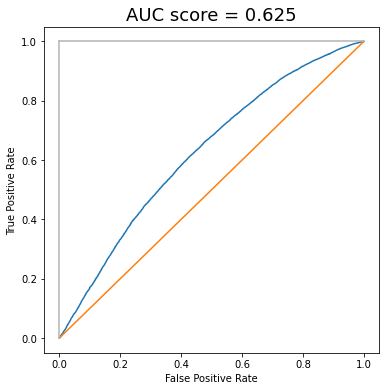

In [28]:
pr, tpr, thresholds = roc_curve(df_test.Label, log_model.predict_proba(df_test_avg[features])[:, 1])
plt.subplots(1, figsize=(6,6))
plt.title('AUC score = ' + str(round(float(auc_score), 3)), fontsize=18)
plt.plot(pr, tpr)
plt.plot([0, 1])
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- P-R curve

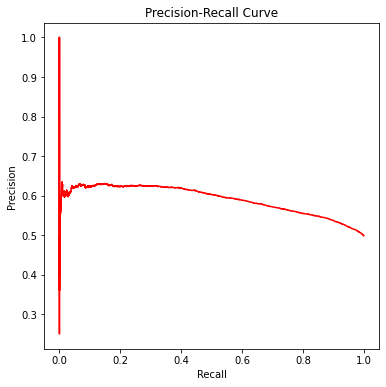

In [29]:
precision, recall, thresholds = precision_recall_curve(df_test.Label, \
                                                       log_model.predict_proba(df_test_avg[features])[:, 1])
plt.subplots(1, figsize=(6,6))
plt.plot(recall, precision, color='red')
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

## Model persistence (5pts)

In [30]:
import joblib
joblib.dump(final_model, "final_model.pkl")
final_model = joblib.load("final_model.pkl")

### Output as a text file for website

In [31]:
label_avg = pd.DataFrame()
for i in Labels.index:
    label_avg = label_avg.append(get_ave(get_neighbor(i)).loc[features], ignore_index=True)

In [32]:
pred = pd.DataFrame(final_model.predict(label_avg))
pred.columns = ['pred']
pred.index = Labels.index
result = Labels.join(pred)
result.to_csv('result.txt', sep='\t')

## Test set 2 (20pts)

### Please run the entire cell when you are grading! Thank you!

In [33]:
# Please run the entire cell when you are grading! Thank you!

def get_neighbor(ID):
    UniProt = ID[0]
    pos = ID[1]
    length = len(UniProt2Seq.loc[UniProt])
    if pos in [1, 2]:
        temp = UniProt2Seq.loc[UniProt][:5]
    elif pos in [length, length-1]:
        temp = UniProt2Seq.loc[UniProt][length-4:]
    else:
        temp = UniProt2Seq.loc[UniProt][pos-3:pos+2]
    return list(temp.AA)


def get_ave(result):
    return Expasy_AA_Scales.loc[result].mean()


def final_function(testset2):
    import pandas as pd
    from sklearn.metrics import roc_auc_score
    import joblib
    test = pd.read_csv(testset2, sep='\t')
    UniProt2Seq = pd.read_csv('UniProt2Seq.txt', sep='\t')
    Expasy_AA_Scales = pd.read_csv('Expasy_AA_Scales.txt', sep='\t')
    
    UniProt2Seq.set_index(['UniProt', 'Position'], inplace=True)
    index_to_drop = [UniProt2Seq.loc[UniProt2Seq['AA'] == 'U'].index, UniProt2Seq.loc[UniProt2Seq['AA'] == 'X'].index]
    UniProt2Seq.drop([index_to_drop[0][0], index_to_drop[1][0]], axis=0, inplace=True)
    test.set_index(['UniProt', 'Position'], inplace=True)
    Expasy_AA_Scales.set_index('Amino Acid', inplace=True)
    final_model = joblib.load("final_model.pkl")
    
    test_avg = pd.DataFrame()
    for i in test.index:
        test_avg = test_avg.append(get_ave(get_neighbor(i)), ignore_index=True)
    prob = final_model.predict_proba(test_avg[features])[:, 1]
    auc_score = roc_auc_score(test.Label, prob)
    return auc_score

**Thank you very much for your reading and grading my final exam!**